In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

print(sys.executable)
print("Environment OK")

/Users/teodoro.bevilacqua/Desktop/Job Market Signal Monitor/.venv/bin/python
Environment OK


In [2]:
from pathlib import Path
import pandas as pd

PROJECT_ROOT = Path.cwd().parent  # assumes you're inside /notebooks
RAW_DIR = PROJECT_ROOT / "data" / "raw"

# list candidate files
candidates = sorted(list(RAW_DIR.glob("*.csv")))
if not candidates:
    raise FileNotFoundError(
        f"No CSV found in {RAW_DIR}. Put your Kaggle CSV there."
    )

print("Found CSV files:")
for i, p in enumerate(candidates):
    print(f"{i}: {p.name}")

# pick the first by default (change index if needed)
csv_path = candidates[0]
print("\nUsing:", csv_path.name)

df = pd.read_csv(csv_path)
df.head(3)

Found CSV files:
0: linkedin_job_postings.csv

Using: linkedin_job_postings.csv


,job_id,company_name,title,description,max_salary,pay_period,location,company_id,views,med_salary,...,skills_desc,listed_time,posting_domain,sponsored,work_type,currency,compensation_type,normalized_salary,zip_code,fips
0,921716,Corcoran Sawyer Smith,Marketing Coordinator,Job descriptionA leading real estate firm in N...,20.0,HOURLY,"Princeton, NJ",2774458.0,20.0,NaN,...,Requirements: \n\nWe are seeking a College or ...,1.713398e+12,NaN,0,FULL_TIME,USD,BASE_SALARY,38480.0,8540.0,34021.0
1,1829192,NaN,Mental Health Therapist/Counselor,"At Aspen Therapy and Wellness , we are committ...",50.0,HOURLY,"Fort Collins, CO",NaN,1.0,NaN,...,NaN,1.712858e+12,NaN,0,FULL_TIME,USD,BASE_SALARY,83200.0,80521.0,8069.0
2,10998357,The National Exemplar,Assitant Restaurant Manager,The National Exemplar is accepting application...,65000.0,YEARLY,"Cincinnati, OH",64896719.0,8.0,NaN,...,We are currently accepting resumes for FOH - A...,1.713278e+12,NaN,0,FULL_TIME,USD,BASE_SALARY,55000.0,45202.0,39061.0


In [3]:
print("Shape:", df.shape)
print("\nColumns:")
print(df.columns.tolist())
df.sample(3, random_state=42)

Shape: (123849, 31)

Columns:
['job_id', 'company_name', 'title', 'description', 'max_salary', 'pay_period', 'location', 'company_id', 'views', 'med_salary', 'min_salary', 'formatted_work_type', 'applies', 'original_listed_time', 'remote_allowed', 'job_posting_url', 'application_url', 'application_type', 'expiry', 'closed_time', 'formatted_experience_level', 'skills_desc', 'listed_time', 'posting_domain', 'sponsored', 'work_type', 'currency', 'compensation_type', 'normalized_salary', 'zip_code', 'fips']


,job_id,company_name,title,description,max_salary,pay_period,location,company_id,views,med_salary,...,skills_desc,listed_time,posting_domain,sponsored,work_type,currency,compensation_type,normalized_salary,zip_code,fips
73989,3902944011,Current Power,Senior Automation Engineer - Power Systems,The Senior Automation / Power Systems Engineer...,NaN,NaN,"Houston, TX",760913.0,22.0,NaN,...,NaN,1.713280e+12,NaN,0,FULL_TIME,NaN,NaN,NaN,77002.0,48201.0
59308,3901960222,DISH Network,DISH Installation Technician - Field,"Company Summary\n\nDISH, an EchoStar Company, ...",19.75,HOURLY,"Orange, TX",4296.0,5.0,NaN,...,NaN,1.713478e+12,jobs.dish.com,0,FULL_TIME,USD,BASE_SALARY,41080.0,77630.0,48361.0
44663,3900944095,"Coca-Cola Bottling Company UNITED, Inc.",Order Builder,Division: North Alabama\n\nDepartment : Oxford...,NaN,NaN,"Oxford, AL",136791.0,4.0,NaN,...,NaN,1.713389e+12,careers.cokeonena.com,0,FULL_TIME,NaN,NaN,NaN,36203.0,1015.0


In [4]:
cols = [c.lower() for c in df.columns]
print("\nLikely title columns:", [df.columns[i] for i,c in enumerate(cols) if "title" in c])
print("Likely description columns:", [df.columns[i] for i,c in enumerate(cols) if "desc" in c or "description" in c])
print("Likely location columns:", [df.columns[i] for i,c in enumerate(cols) if "loc" in c or "city" in c or "country" in c])
print("Likely date columns:", [df.columns[i] for i,c in enumerate(cols) if "date" in c or "posted" in c or "time" in c])


Likely title columns: ['title']
Likely description columns: ['description', 'skills_desc']
Likely location columns: ['location']
Likely date columns: ['original_listed_time', 'closed_time', 'listed_time']


In [5]:
df_core = (
    df[["title", "description", "location", "listed_time"]]
    .rename(columns={"listed_time": "date"})
    .copy()
)

df_core.head(3)

,title,description,location,date
0,Marketing Coordinator,Job descriptionA leading real estate firm in N...,"Princeton, NJ",1.713398e+12
1,Mental Health Therapist/Counselor,"At Aspen Therapy and Wellness , we are committ...","Fort Collins, CO",1.712858e+12
2,Assitant Restaurant Manager,The National Exemplar is accepting application...,"Cincinnati, OH",1.713278e+12


In [6]:
df_core["date"] = pd.to_datetime(df_core["date"], unit="ms", errors="coerce")

df_core["date"].head()

df_core["date"].min(), df_core["date"].max()

(Timestamp('2024-03-24 21:50:14'), Timestamp('2024-04-20 00:26:56'))

In [7]:
initial_rows = len(df_core)

df_core = df_core.dropna(subset=["title", "description", "date"])
df_core = df_core[df_core["description"].str.len() >= 100]

final_rows = len(df_core)

print(f"Rows before: {initial_rows}")
print(f"Rows after : {final_rows}")
print(f"Kept {final_rows / initial_rows:.1%} of data")

Rows before: 123849
Rows after : 123700
Kept 99.9% of data


In [8]:
import re

def clean_text(text: str) -> str:
    text = text.lower()
    text = re.sub(r"<[^>]+>", " ", text)      # remove HTML
    text = re.sub(r"\s+", " ", text).strip()  # normalize spaces
    return text

df_core["title_clean"] = df_core["title"].apply(clean_text)
df_core["description_clean"] = df_core["description"].apply(clean_text)

df_core[["title_clean", "description_clean"]].head(2)

,title_clean,description_clean
0,marketing coordinator,job descriptiona leading real estate firm in n...
1,mental health therapist/counselor,"at aspen therapy and wellness , we are committ..."


In [9]:
df_core.info()
df_core.sample(3, random_state=42)

<class 'pandas.core.frame.DataFrame'>
Index: 123700 entries, 0 to 123848
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   title              123700 non-null  object        
 1   description        123700 non-null  object        
 2   location           123700 non-null  object        
 3   date               123700 non-null  datetime64[ns]
 4   title_clean        123700 non-null  object        
 5   description_clean  123700 non-null  object        
dtypes: datetime64[ns](1), object(5)
memory usage: 6.6+ MB


,title,description,location,date,title_clean,description_clean
87591,Professional Pharmaceutical Sales Representative,Description\n\nYou have what it takes: a compe...,"Evansville, IN",2024-04-17 22:45:06,professional pharmaceutical sales representative,description you have what it takes: a competit...
39975,"Environmental Technician (Onsite Role in Ames,...","At Hach (www.hach.com), we ensure water qualit...","Des Moines, IA",2024-04-15 20:20:01,"environmental technician (onsite role in ames,...","at hach (www.hach.com), we ensure water qualit..."
77686,Mixed Commercial Construction Superintendent,About Us: I am working with a leading construc...,"Austin, Texas Metropolitan Area",2024-04-18 18:57:25,mixed commercial construction superintendent,about us: i am working with a leading construc...


In [10]:
from pathlib import Path
PROCESSED_DIR = PROJECT_ROOT / "data" / "processed"
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)

out_path = PROCESSED_DIR / "job_postings_clean.parquet"
df_core.to_parquet(out_path, index=False)

print("Saved to:", out_path)

Saved to: /Users/teodoro.bevilacqua/Desktop/Job Market Signal Monitor/data/processed/job_postings_clean.parquet


In [11]:
df_time = df_core.copy()
df_time = df_time.set_index("date").sort_index()

df_time.head(3)

,title,description,location,title_clean,description_clean
date,,,,,
2024-03-24 21:50:14,Warehouse Worker/Cover Driver,SHIFT YOUR FUTURE\n\nWarehouse Worker/Temporar...,"Springfield, VA",warehouse worker/cover driver,shift your future warehouse worker/temporary c...
2024-04-05 19:34:32,Cloud Engineer,hackajob transforms your job search into a per...,"Suitland, MD",cloud engineer,hackajob transforms your job search into a per...
2024-04-05 19:34:32,Seasonal Teller - Layhill,About Us\n\nAre you someone who seeks opportun...,"Silver Spring, MD",seasonal teller - layhill,about us are you someone who seeks opportunity...


In [18]:
import pandas as pd

split_date = df_time.index.min() + (df_time.index.max() - df_time.index.min()) / 2

df_time["period"] = [
    "early_period" if d <= split_date else "late_period"
    for d in df_time.index
]

print("Split date:", split_date)
df_time["period"].value_counts()

df_time.groupby("period").apply(lambda x: (x.index.min(), x.index.max()))

Split date: 2024-04-06 23:08:35


/var/folders/1q/vr4txqzd4tnfknzdbd0rc3nw0000gn/T/ipykernel_7941/2576741366.py:13: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_time.groupby("period").apply(lambda x: (x.index.min(), x.index.max()))


period
early_period    (2024-03-24 21:50:14, 2024-04-06 23:08:07)
late_period     (2024-04-06 23:08:41, 2024-04-20 00:26:56)
dtype: object

/var/folders/1q/vr4txqzd4tnfknzdbd0rc3nw0000gn/T/ipykernel_7941/3869280475.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample("M")


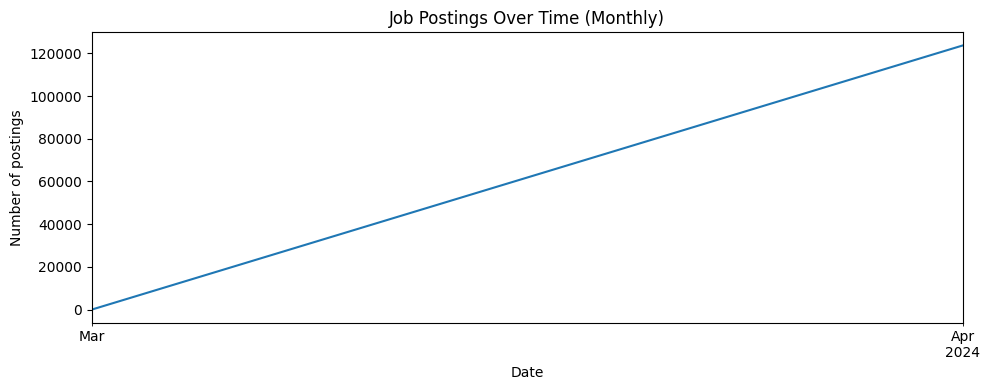

In [12]:
monthly_counts = (
    df_time
    .resample("M")
    .size()
    .rename("num_postings")
)

monthly_counts.head()

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
monthly_counts.plot()
plt.title("Job Postings Over Time (Monthly)")
plt.ylabel("Number of postings")
plt.xlabel("Date")
plt.tight_layout()
plt.show()

In [13]:
print("Start date:", monthly_counts.index.min().date())
print("End date  :", monthly_counts.index.max().date())
print("Total months:", len(monthly_counts))

Start date: 2024-03-31
End date  : 2024-04-30
Total months: 2


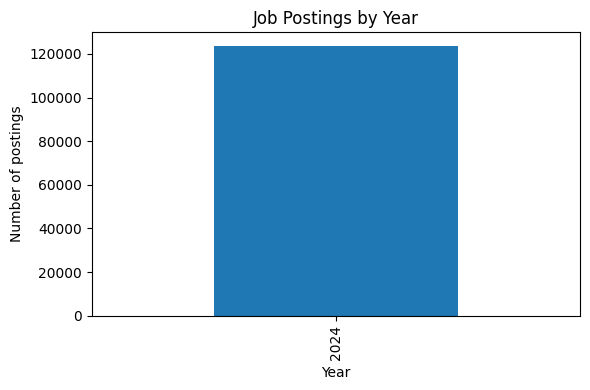

In [14]:
yearly_counts = (
    df_time
    .groupby(df_time.index.year)
    .size()
)

yearly_counts

plt.figure(figsize=(6, 4))
yearly_counts.plot(kind="bar")
plt.title("Job Postings by Year")
plt.ylabel("Number of postings")
plt.xlabel("Year")
plt.tight_layout()
plt.show()

In [15]:
top_titles = (
    df_time["title_clean"]
    .value_counts()
    .head(10)
    .index
)

top_titles

Index(['sales manager', 'customer service representative', 'project manager',
       'assistant store manager', 'administrative assistant',
       'senior accountant', 'salesperson', 'executive assistant',
       'registered nurse', 'receptionist'],
      dtype='object', name='title_clean')

/var/folders/1q/vr4txqzd4tnfknzdbd0rc3nw0000gn/T/ipykernel_7941/2820517605.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .groupby([pd.Grouper(freq="M"), "title_clean"])
/Users/teodoro.bevilacqua/Desktop/Job Market Signal Monitor/.venv/lib/python3.12/site-packages/pandas/plotting/_matplotlib/core.py:1567: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(left, right)
/Users/teodoro.bevilacqua/Desktop/Job Market Signal Monitor/.venv/lib/python3.12/site-packages/pandas/plotting/_matplotlib/core.py:1567: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(left, right)
/Users/teodoro.bevilacqua/Desktop/Job Market Signal Monitor/.venv/lib/python3.12/site-packages/pandas/plotting/_matplotlib/core.py:1567: UserWarning: Attempting to set identical low and high xlims makes transfo

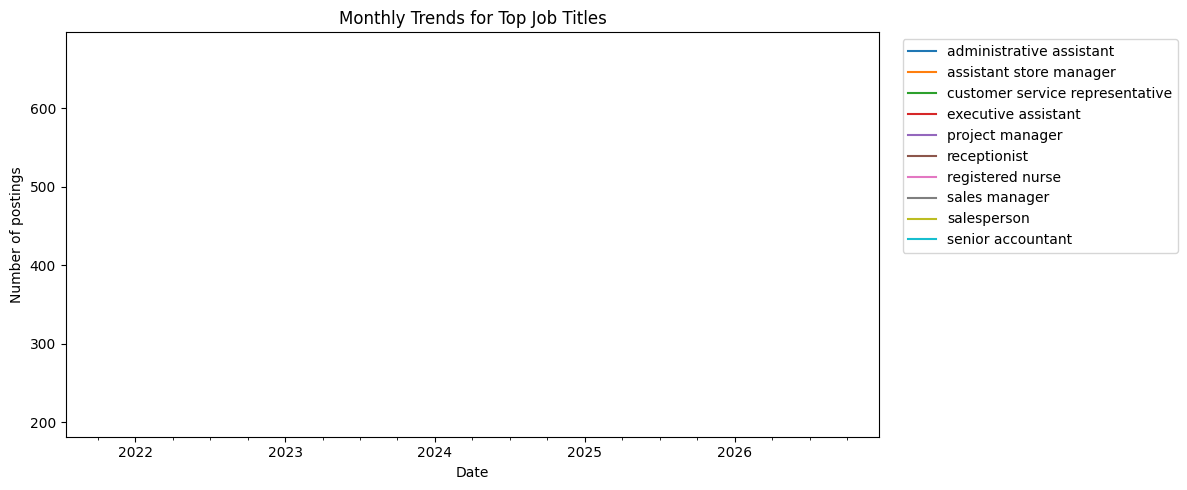

In [16]:
title_trends = (
    df_time[df_time["title_clean"].isin(top_titles)]
    .groupby([pd.Grouper(freq="M"), "title_clean"])
    .size()
    .unstack(fill_value=0)
)

title_trends.head()

plt.figure(figsize=(12, 5))
title_trends.plot(ax=plt.gca())
plt.title("Monthly Trends for Top Job Titles")
plt.ylabel("Number of postings")
plt.xlabel("Date")
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()

The dataset covers a short but dense time window from late March to April 2024.
While this limits long-term trend analysis, it is well suited for cross-sectional and short-term signal extraction.
Posting activity remains consistent across the window, suggesting stable data ingestion rather than sporadic scraping.
This scope supports semantic clustering of roles and skills, as well as comparative analysis between sub-periods and locations.